In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

### MELD Data

In [ ]:
# download MELD
%cd '/content/drive/MyDrive/NEED'
!git clone https://github.com/declare-lab/MELD.git

In [ ]:
import pandas as pd
# specify test filename
file_name = "/content/drive/MyDrive/NEED/MELD/data/MELD/test_sent_emo.csv" 
utter_column = "Utterance" 
emo_column = "Emotion"

# read in csv
df = pd.read_csv(file_name)
MELD_utter = df[utter_column].astype('str').tolist()
MELD_emo = df[emo_column].astype('str').tolist()

In [ ]:
df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all you’re coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. That’s so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [ ]:
assert len(MELD_utter) == len(MELD_emo)
print('Number of Test set:', len(MELD_utter))
print('Emotion Classes:', set(df[emo_column].tolist()))

Number of Test set: 2610
Emotion Classes: {'neutral', 'sadness', 'fear', 'surprise', 'disgust', 'anger', 'joy'}


### DailyDialog

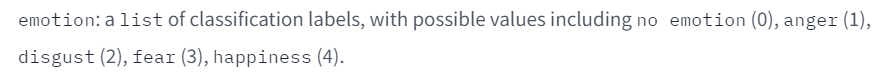

maybe sadness(5), surprise(6) 

In [ ]:
!pip install datasets
from datasets import load_dataset
daily_dial_dataset = load_dataset("daily_dialog")

In [ ]:
# merge lists to change a dialogue to utterances
DD_utter = sum(daily_dial_dataset['test']['dialog'], [])
DD_emo = sum(daily_dial_dataset['test']['emotion'], [])

In [ ]:
DD_utter[:10]

['Hey man , you wanna buy some weed ? ',
 ' Some what ? ',
 ' Weed ! You know ? Pot , Ganja , Mary Jane some chronic ! ',
 ' Oh , umm , no thanks . ',
 ' I also have blow if you prefer to do a few lines . ',
 ' No , I am ok , really . ',
 ' Come on man ! I even got dope and acid ! Try some ! ',
 ' Do you really have all of these drugs ? Where do you get them from ? ',
 ' I got my connections ! Just tell me what you want and I ’ ll even give you one ounce for free . ',
 ' Sounds good ! Let ’ s see , I want . ']

In [ ]:
DD_emo[:10]

[0, 6, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
assert len(DD_utter) == len(DD_emo)
print('Number of Test set:', len(DD_utter))
print('Emotion Classes:', set(DD_emo))

Number of Test set: 7740
Emotion Classes: {0, 1, 2, 3, 4, 5, 6}


In [ ]:
# %cd '/content/drive/MyDrive/NEED'
# !git clone https://github.com/Sanghoon94/DailyDialogue-Parser.git
# %cd '/content/drive/MyDrive/NEED/DailyDialogue-Parser'
# %run parser.py -i /content/drive/MyDrive/NEED/ijcnlp_dailydialog/test -o /content/drive/MyDrive/NEED/ijcnlp_dailydialog/test_parsed
# with open('/content/drive/MyDrive/NEED/ijcnlp_dailydialog/test_parsed/dial.txt') as f:
#     dial = f.read()
#     texts = dial.splitlines()
# with open('/content/drive/MyDrive/NEED/ijcnlp_dailydialog/test_parsed/emo.txt') as f:
#     emo = f.read()
#     emos = emo.splitlines()

# assert len(emos) == len(texts) 

# Load Emotion-English-DistilRoBERTa-base

In [ ]:
# install the transformers library
!pip install transformers

In [ ]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
model.config.id2label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

# Inference

### Classify utters with model (MELD)

In [ ]:
# Tokenize texts and create prediction data set
MELD_tokenized_texts = tokenizer(MELD_utter,truncation=True,padding=True)
MELD_pred_dataset = SimpleDataset(MELD_tokenized_texts)

In [ ]:
# Run predictions
MELD_predictions = trainer.predict(MELD_pred_dataset)

***** Running Prediction *****
  Num examples = 2610
  Batch size = 8


In [ ]:
# Transform predictions to labels
MELD_preds = MELD_predictions.predictions.argmax(-1)
MELD_labels = pd.Series(MELD_preds).map(model.config.id2label)
MELD_scores = (np.exp(MELD_predictions[0])/np.exp(MELD_predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# # scores raw
# temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# # work in progress
# # container
# anger = []
# disgust = []
# fear = []
# joy = []
# neutral = []
# sadness = []
# surprise = []

# # extract scores (as many entries as exist in pred_texts)
# for i in range(len(pred_texts)):
#   anger.append(temp[i][0])
#   disgust.append(temp[i][1])
#   fear.append(temp[i][2])
#   joy.append(temp[i][3])
#   neutral.append(temp[i][4])
#   sadness.append(temp[i][5])
#   surprise.append(temp[i][6])

In [ ]:
# # Create DataFrame with texts, predictions, labels, and scores
# df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores,  anger, disgust, fear, joy, neutral, sadness, surprise)), columns=['text','pred','label','score', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])
# df.head()

In [ ]:
MELD_pred_df = pd.DataFrame(list(zip(MELD_utter,MELD_preds,MELD_labels)), columns=['utter','pred','label'])
MELD_pred_df[:10]

,utter,pred,label
0,Why do all you’re coffee mugs have numbers on ...,6,surprise
1,Oh. That’s so Monica can keep track. That way ...,4,neutral
2,Y'know what?,0,anger
3,"Come on, Lydia, you can do it.",4,neutral
4,Push!,0,anger
5,"Push 'em out, push 'em out, harder, harder.",0,anger
6,"Push 'em out, push 'em out, way out!",0,anger
7,"Let's get that ball and really move, hey, hey,...",4,neutral
8,"Let's— I was just—yeah, right.",4,neutral
9,Push!,0,anger


In [ ]:
# label setting
MELD_label = np.zeros(len(MELD_utter))
MELD_emo = np.array(MELD_emo)
MELD_label[MELD_emo=='anger'] = 0
MELD_label[MELD_emo=='disgust'] = 1
MELD_label[MELD_emo=='fear'] = 2
MELD_label[MELD_emo=='joy'] = 3
MELD_label[MELD_emo=='neutral'] = 4
MELD_label[MELD_emo=='sadness'] = 5
MELD_label[MELD_emo=='surprise'] = 6

# pred setting
MELD_pred = np.array(MELD_pred_df['pred'], dtype=int)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(MELD_label, MELD_pred) 
print("**************************************")
print(f'Confusion Matrix :\n {cm}\n') 
print("**************************************")
print(f'Test Set Accuracy Score :\n {accuracy_score(MELD_label, MELD_pred)}\n') 
print("**************************************")
print(f'Classification Report :\n {classification_report(MELD_label, MELD_pred)}')

**************************************
Confusion Matrix :
 [[118  42  11  20  60   5  89]
 [ 11  23   1   3  15   1  14]
 [ 10   5   8   1  10   2  14]
 [ 53  20   4 163  65  11  86]
 [ 74  83  33  76 744  42 204]
 [ 29  20  13  12  61  39  34]
 [ 34  11   1  12  17   0 206]]

**************************************
Test Set Accuracy Score :
 0.4984674329501916

**************************************
Classification Report :
               precision    recall  f1-score   support

         0.0       0.36      0.34      0.35       345
         1.0       0.11      0.34      0.17        68
         2.0       0.11      0.16      0.13        50
         3.0       0.57      0.41      0.47       402
         4.0       0.77      0.59      0.67      1256
         5.0       0.39      0.19      0.25       208
         6.0       0.32      0.73      0.44       281

    accuracy                           0.50      2610
   macro avg       0.38      0.39      0.36      2610
weighted avg       0.57      0

### Classify utters with model (DailyDialog)

In [ ]:
# Tokenize texts and create prediction data set
DD_tokenized_texts = tokenizer(DD_utter,truncation=True,padding=True)
DD_pred_dataset = SimpleDataset(DD_tokenized_texts)

In [ ]:
# Run predictions
DD_predictions = trainer.predict(DD_pred_dataset)

***** Running Prediction *****
  Num examples = 7740
  Batch size = 8


In [ ]:
# Transform predictions to labels
DD_preds = DD_predictions.predictions.argmax(-1)
DD_labels = pd.Series(DD_preds).map(model.config.id2label)
DD_scores = (np.exp(DD_predictions[0])/np.exp(DD_predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
DD_pred_df = pd.DataFrame(list(zip(DD_utter,DD_preds,DD_labels)), columns=['utter','pred','label'])
DD_pred_df[:10]

,utter,pred,label
0,"Hey man , you wanna buy some weed ?",2,fear
1,Some what ?,2,fear
2,"Weed ! You know ? Pot , Ganja , Mary Jane som...",4,neutral
3,"Oh , umm , no thanks .",2,fear
4,I also have blow if you prefer to do a few li...,4,neutral
5,"No , I am ok , really .",2,fear
6,Come on man ! I even got dope and acid ! Try ...,0,anger
7,Do you really have all of these drugs ? Where...,6,surprise
8,I got my connections ! Just tell me what you ...,4,neutral
9,"Sounds good ! Let ’ s see , I want .",3,joy


In [ ]:
# label setting
DD_label = np.zeros(len(DD_utter), dtype=int)
DD_emo = np.array(DD_emo)
DD_label[DD_emo==0] = 4
DD_label[DD_emo==1] = 0
DD_label[DD_emo==2] = 1
DD_label[DD_emo==3] = 2
DD_label[DD_emo==4] = 3
DD_label[DD_emo==5] = 5
DD_label[DD_emo==6] = 6

# pred setting
DD_pred = np.array(DD_pred_df['pred'], dtype=int)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cm = confusion_matrix(DD_label, DD_pred) 
print("**************************************")
print(f'Confusion Matrix :\n {cm}\n') 
print("**************************************")
print(f'Test Set Accuracy Score :\n {accuracy_score(DD_label, DD_pred)}\n') 
print("**************************************")
print(f'Classification Report :\n {classification_report(DD_label, DD_pred)}')

**************************************
Confusion Matrix :
 [[  32    5   29    0   31   15    6]
 [   8   13    9    0    7    9    1]
 [   1    0   15    0    1    0    0]
 [   9    9   92  467  385   10   47]
 [ 140  143 1599  415 3545  284  195]
 [   7    5   23    2   19   42    4]
 [  10    2   26    4   23    2   49]]

**************************************
Test Set Accuracy Score :
 0.5378552971576227

**************************************
Classification Report :
               precision    recall  f1-score   support

           0       0.15      0.27      0.20       118
           1       0.07      0.28      0.12        47
           2       0.01      0.88      0.02        17
           3       0.53      0.46      0.49      1019
           4       0.88      0.56      0.69      6321
           5       0.12      0.41      0.18       102
           6       0.16      0.42      0.23       116

    accuracy                           0.54      7740
   macro avg       0.27      0.47  

### Export results

In [ ]:
# save results to csv
YOUR_FILENAME = "YOUR_FILENAME_EMOTIONS.csv"  # name your output file
df.to_csv(YOUR_FILENAME)

In [ ]:
# download file
files.download(YOUR_FILENAME)